<a href="https://colab.research.google.com/github/DereAbdulhameed/whisper/blob/main/Copy_of_Clinify_Fine_Tune_WHisper_on_Fleurs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Fine-tuning MMS Adapter Models for Multi-Lingual ASR**

***New (06/2023)***: *This blog post is strongly inspired by "Fine-tuning XLS-R on Multi-Lingual ASR" https://huggingface.co/blog/fine-tune-xlsr-wav2vec2* and can be seen as an improved version of it.

**Wav2Vec2** is a pretrained model for Automatic Speech Recognition (ASR) and was released in [September 2020](https://ai.facebook.com/blog/wav2vec-20-learning-the-structure-of-speech-from-raw-audio/) by *Alexei Baevski, Michael Auli, and Alex Conneau*.  Soon after the superior performance of Wav2Vec2 was demonstrated on one of the most popular English datasets for ASR, called [LibriSpeech](https://huggingface.co/datasets/librispeech_asr), *Facebook AI* presented a multi-lingual version of Wav2Vec2, called [XLSR](https://arxiv.org/abs/2006.13979) and [XLS-R](https://ai.facebook.com/blog/-xlm-r-state-of-the-art-cross-lingual-understanding-through-self-supervision/). XLSR stands for *cross-lingual speech representations* and refers to model's ability to learn speech representations that are useful across multiple languages.

MetaAI's most recent release, the [**Massive Multilingual Speech (MMS)**](https://ai.facebook.com/blog/multilingual-model-speech-recognition/) by *Vineel Pratap, Andros Tjandra, Bowen Shi, et al.* takes multi-lingual speech representations to a new level. Over 1000 spoken languages can be identified, transcribed and generated with the [ASR, LID and TTS checkpoints that were released](https://huggingface.co/models?other=mms).

In this blog post, we show how MMS's Adapter training achieves astonishingly low word error rates after just 10-20 minutes of fine-tuning.

For low-resource languages, we **strongly** recommend using MMS' Adapter training as opposed to fine-tuning the whole model as is done in ["Fine-tuning XLS-R on Multi-Lingual ASR"](https://huggingface.co/blog/fine-tune-xlsr-wav2vec2).

In our experiments, MMS' Adapter training is both more memory efficient, more robust and yields better performance for low-resource languages. For medium to high resource languages it can still be advantegous to fine-tune the whole checkpoint instead of using Adapter layers though.

![wav2vec2_structure](https://raw.githubusercontent.com/patrickvonplaten/scientific_images/master/mms_map.png)


## **Preserving the world's language diversity**

According to https://www.ethnologue.com/ around 3000, or 40% of all "living" languages, are endangered due to fewer and fewer native speakers.
This trend will only continue in an increasingly globalized world.

**MMS** is capable of transcribing many languages which are endangered, such as *Ari* or *Kaivi*. In the future, MMS can play a vital role in keeping languages alive by helping the remaining speakers to create written records and communicating in their native tongue.

To adapt to 1000+ different vocabularies, **MMS** uses of Adapters - a training method where only a small fraction of model weights are trained.

Adapter layers act like linguistic bridges, enabling the model to leverage knowledge from one language when deciphering another.

## **Fine-tuning MMS**

**MMS** unsupervised checkpoints were pre-trained on more than **half a million** hour of audio in over **1400** languages ranging from 300 million to one billion parameters.

You can find the pretrained-only checkpoints on the 🤗 Hub:

- [**`mms-300m`**](https://huggingface.co/facebook/mms-300m)
- [**`mms-1b`**](https://huggingface.co/facebook/mms-1b)

Similar to [BERT's masked language modeling objective](http://jalammar.github.io/illustrated-bert/), MMS learns contextualized speech representations by randomly masking feature vectors before passing them to a transformer network during self-supervised pre-training (*i.e.* diagram on the left below).

For Automatic Speech Recognitino (ASR), the pretrained `MMS-1B` checkpoint was further fine-tuned in supervised fasion on 1000+ languages with a joint vocabulary output layer. As a final step, the joint vocabulary output layer was then thrown away and **only** ca. 2.5M adapter weights are trained on specific languages. The adapter weights hereby include small linear projection layers for each attention block as well as a language-specific vocabulary output layer.

**MMS**'s released three checkpoints fine-tuned for speech recognition (ASR) that have 102, 1107, and 1162 adapter weights respectively (one for each language):

- [**`mms-1b-fl102`**](https://huggingface.co/facebook/mms-1b-fl102)
- [**`mms-1b-l1107`**](https://huggingface.co/facebook/mms-1b-1107)
- [**`mms-1b-all`**](https://huggingface.co/facebook/mms-1b-all)

You can see that the base models are saved (as usual) as a [`model.safetensors` file](https://huggingface.co/facebook/mms-1b-all/blob/main/model.safetensors), but in addition these repositories have many adapter weights stored in the repository, *e.g.* under the name [`adapter.fra.safetensors`](https://huggingface.co/facebook/mms-1b-all/blob/main/adapter.fra.safetensors) for French.

The Hugging Face docs explain very well how such checkpoints can be used for inference [here](https://huggingface.co/docs/transformers/main/en/model_doc/mms#loading), so in this blog post we will instead focus on learning how we can efficiently train highly performant adapter models based on any of the released ASR checkpoints.

## Training adaptive weights

In machine learning, [adapters](https://arxiv.org/pdf/1902.00751.pdf) are a method used to fine-tune pre-trained models while keeping the original model parameters unchanged. They do this by inserting small, trainable modules, called adapter layers, between the pre-existing layers of the model, which then adapt the model to a specific task without requiring extensive retraining.

Adapters have a long history in speech recognition and especially **speaker recognition**. In speaker recognition, adapters have been effectively used to tweak pre-existing models to recognize individual speaker idiosyncrasies, as highlighted in [Gales and Woodland's (1996)](https://www.isca-speech.org/archive_v0/archive_papers/icslp_1996/i96_1832.pdf) and [Miao et al.'s (2014)](https://www.cs.cmu.edu/~ymiao/pub/tasl_sat.pdf) work. This approach not only greatly reduces computational requirements compared to full model, but also allows for better and more flexible speaker-specific adjustments.

The work done in **MMS** leverages this idea of adapters for speech recognition across different languages. Adapter weights a fine-tuned to grasp unique phonetic and grammatical traits of each target language. Thereby, MMS enables a single large base model (*e.g.*, the [**`mms-1b-all`**](https://huggingface.co/facebook/mms-1b-all) checkpoint) and 1000+ small adapter layers (2.5M weights each for **`mms-1b-all`**) to comprehend and transcribe multiple languages. This dramatically reduces the computational demand of developing distinct models for each language.

Great! Now that we understood the motivation and theory, let's look into fine-tuning a couple adapter weights for **`mms-1b-all`** 🔥

## Notebook Setup

As done previously in the ["Fine-tuning XLS-R on Multi-Lingual ASR"](https://huggingface.co/blog/fine-tune-xlsr-wav2vec2) blog post, we fine-tune the model on the low resource ASR dataset of [Common Voice](https://huggingface.co/datasets/common_voice) that contains only *ca.* 4h of validated training data.

Just like Wav2Vec2 or XLS-R, MMS is fine-tuned using Connectionist Temporal Classification (CTC), which is an algorithm that is used to train neural networks for sequence-to-sequence problems, such as ASR and handwriting recognition.

I highly recommend reading the well-written blog post [*Sequence Modeling with CTC (2017)*](https://distill.pub/2017/ctc/) by Awni Hannun.

First, let's try to get a good GPU in our colab! With Google Colab's free version it's sadly becoming much harder to get access to a good GPU. With Google Colab Pro, however, one should easily get either a V100 or P100 GPU.

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Thu Mar  7 00:42:46 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0              46W / 400W |      2MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

Before we start, let's install `datasets` and `transformers`. Also, we need the `torchaudio` to load audio files and `jiwer` to evaluate our fine-tuned model using the [word error rate (WER)](https://huggingface.co/metrics/wer) metric ${}^1$.

In [ ]:
%%capture
!pip install datasets[audio]
!pip install evaluate
!pip install git+https://github.com/huggingface/transformers.git
!pip install jiwer
!pip install accelerate

We strongly suggest to upload your training checkpoints directly to the [🤗 Hub](https://huggingface.co/) while training. The [🤗 Hub](https://huggingface.co/) has integrated version control so you can be sure that no model checkpoint is getting lost during training.

To do so you have to store your authentication token from the Hugging Face website (sign up [here](https://huggingface.co/join) if you haven't already!)

In [ ]:
pip install accelerate -U

In [ ]:
pip install transformers[torch]

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

## Prepare Data, Tokenizer, Feature Extractor

ASR models transcribe speech to text, which means that we both need a feature extractor that processes the speech signal to the model's input format, *e.g.* a feature vector, and a tokenizer that processes the model's output format to text.

In 🤗 Transformers, the MMS model is thus accompanied by both a tokenizer, called [Wav2Vec2CTCTokenizer](https://huggingface.co/transformers/master/model_doc/wav2vec2.html#wav2vec2ctctokenizer), and a feature extractor, called [Wav2Vec2FeatureExtractor](https://huggingface.co/transformers/master/model_doc/wav2vec2.html#wav2vec2featureextractor).

Let's start by creating the tokenizer to decode the predicted output classes to the output transcription.

### Create `Wav2Vec2CTCTokenizer`

Fine-tuned MMS models, such as [**`mms-1b-all`**](https://huggingface.co/facebook/mms-1b-all) already have a [tokenizer](https://huggingface.co/facebook/mms-1b-all/blob/main/tokenizer_config.json) accompanying the model checkpoint. However since we want to fine-tune the model on specific low-resource data of a certain language, it is recommended to fully remove the tokenizer, and vocabulary output layer and simply create a new ones based on the training data itself.

Remember that Wav2Vec2-like models fine-tuned on CTC transcribe an audio file with a single forward pass by first processing the audio input into a secquence of processed context representations and then using the final vocabulary output layer to classify each context representation to a character that reperesents the transcription.

The output size of this layer corresponds to the number of tokens in the vocabulary, and therefore only on the labeled dataset used for fine-tuning. So in the first step, we will take a look at the chosen dataset of Common Voice and define a vocabulary based on the transcriptions.

For this notebook, we will use [Common Voice's 6.1 dataset](https://huggingface.co/datasets/mozilla-foundation/common_voice_6_1) for Turkish. Turkish corresponds to the language code `"tr"`.

Now we can use 🤗 Datasets' simple API to download the data. The dataset name is `"mozilla-foundation/common_voice_6_1"`, the configuration name corresponds to the language code, which is `"tr"` in our case.

**Note**: Before being able to download the dataset, you have to access it by logging into your Hugging Face account, going on the [dataset repo page](https://huggingface.co/datasets/mozilla-foundation/common_voice_6_1) and clicking on:

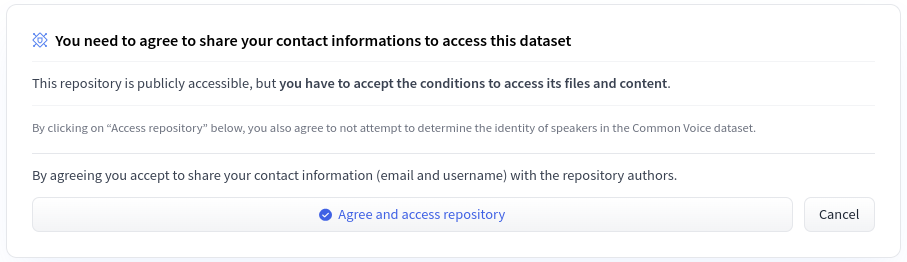

Common Voice has many different splits including `invalidated`, which refers to data that was not rated as "clean enough" to be considered useful. In this notebook, we will only make use of the splits `"train"`, `"validation"` and `"test"`.

Because the Turkish dataset is so small, we will merge both the validation and training data into a training dataset and only use the test data for validation.

In [ ]:
import os
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'max_split_size_mb:128'

In [ ]:
from datasets import interleave_datasets, load_dataset

def load_streaming_dataset(dataset_name, dataset_config_name, split, **kwargs):
    if "+" in split:
        # load multiple splits separated by the `+` symbol *with* streaming mode
        dataset_splits = [load_dataset(dataset_name, dataset_config_name, split=split_name, streaming=True, **kwargs) for split_name in split.split("+")]
        # interleave multiple splits to form one dataset
        interleaved_dataset = interleave_datasets(dataset_splits)
        return interleaved_dataset
    else:
        # load a single split *with* streaming mode
        dataset = load_dataset(dataset_name, dataset_config_name, split=split, streaming=True, **kwargs)
        return dataset

In [ ]:
from datasets import IterableDatasetDict

raw_datasets = IterableDatasetDict()

raw_datasets["train"] = load_streaming_dataset("google/fleurs", "en_us", split="train+validation", use_auth_token=True)  # set split="train+validation" for low-resource
raw_datasets["test"] = load_streaming_dataset("google/fleurs", "en_us", split="test", use_auth_token=True)

In [ ]:
from datasets import IterableDatasetDict

#raw_datasets = IterableDatasetDict()

#raw_datasets["train"] = load_streaming_dataset("mozilla-foundation/common_voice_16_1", "en", split="train+validation", use_auth_token=True)  # set split="train+validation" for low-resource
#raw_datasets["test"] = load_streaming_dataset("mozilla-foundation/common_voice_16_1", "en", split="test", use_auth_token=True)

/usr/local/lib/python3.10/dist-packages/datasets/load.py:1461: FutureWarning: The repository for mozilla-foundation/common_voice_16_1 contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/mozilla-foundation/common_voice_16_1
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


In [ ]:
#from datasets import load_dataset, load_metric, Audio

#common_voice_train = load_dataset("mozilla-foundation/common_voice_6_1", "en", split="train", use_auth_token=True)
#common_voice_test = load_dataset("mozilla-foundation/common_voice_6_1", "en", split="test", use_auth_token=True)


#common_voice_train = load_dataset("mozilla-foundation/common_voice_13_0", "en", split="train[:1]", use_auth_token=True)
#common_voice_test = load_dataset("mozilla-foundation/common_voice_13_0", "en", split="test", use_auth_token=True)



Many ASR datasets only provide the target text, `'sentence'` for each audio array `'audio'` and file `'path'`. Common Voice actually provides much more information about each audio file, such as the `'accent'`, etc. Keeping the notebook as general as possible, we only consider the transcribed text for fine-tuning.



In [ ]:
raw_datasets

IterableDatasetDict({
    train: IterableDataset({
        features: ['id', 'num_samples', 'path', 'audio', 'transcription', 'raw_transcription', 'gender', 'lang_id', 'language', 'lang_group_id'],
        n_shards: 1
    })
    test: IterableDataset({
        features: ['id', 'num_samples', 'path', 'audio', 'transcription', 'raw_transcription', 'gender', 'lang_id', 'language', 'lang_group_id'],
        n_shards: 1
    })
})

In [ ]:
raw_datasets = raw_datasets.remove_columns(["id", "num_samples", "raw_transcription", "gender", "lang_id", "language", "lang_group_id", "path"])
#raw_datasets = raw_datasets.remove_columns(["accent", "age", "client_id", "down_votes", "gender", "locale", "segment", "up_votes", "variant", "path"])
#common_voice_test = common_voice_test.remove_columns(["accent", "age", "client_id", "down_votes", "gender", "locale", "segment", "up_votes"])

In [ ]:
raw_datasets

IterableDatasetDict({
    train: IterableDataset({
        features: ['audio', 'transcription'],
        n_shards: 1
    })
    test: IterableDataset({
        features: ['audio', 'transcription'],
        n_shards: 1
    })
})

Let's write a short function to display some random samples of the dataset and run it a couple of times to get a feeling for the transcriptions.

In [ ]:
import pandas as pd
from IPython.display import display, HTML
import random

def show_random_elements(dataset, num_examples=10):
    sample = []  # To hold sampled examples

    # Try to manually fetch num_examples * 10 examples from the dataset if possible
    try:
        iterator = iter(dataset)
        for _ in range(num_examples * 10):
            sample.append(next(iterator))
    except StopIteration:
        # If the dataset has fewer elements than we tried to fetch, just proceed with what we have
        pass

    # Randomly select num_examples from the sampled examples, if we have enough
    if len(sample) > num_examples:
        picks = random.sample(sample, num_examples)
    else:
        # If we have less than num_examples, use all sampled examples
        picks = sample

    # Create a DataFrame to display the picked examples
    df = pd.DataFrame(picks)
    display(HTML(df.to_html()))

# Assuming raw_datasets is a DatasetDict or similar containing your data
# And assuming that you've correctly identified the dataset split you want to use
# Adjust the function call as necessary, e.g., by specifying the correct dataset split like raw_datasets["train"]
show_random_elements(raw_datasets["train"].remove_columns(['audio']), num_examples=10)


,transcription
0,it had been scheduled to be cut down on tuesday but was saved after an emergency court ruling
1,the first cases of the disease this season were reported in late july
2,thousands of years ago a man called aristarchus said that the solar system moved around the sun
3,"on september 24 1759 arthur guinness signed a 9,000 year lease for the st james' gate brewery in dublin ireland"
4,unattended bags are a target for theft and can also attract attention from authorities wary of bomb threats
5,examples include control planning and scheduling the ability to answer customer diagnoses and questions as well as handwriting recognition voice and face
6,the protest started around 11:00 local time utc+1 on whitehall opposite the police-guarded entrance to downing street the prime minister's official residence
7,with the same time zone as hawaii the islands are sometimes thought of as hawaii down under
8,today timbuktu is an impoverished town although its reputation makes it a tourist attraction and it has an airport
9,the east african islands are in the indian ocean off the eastern coast of africa


Alright! The transcriptions look fairly clean. Having translated the transcribed sentences, it seems that the language corresponds more to written-out text than noisy dialogue. This makes sense considering that [Common Voice](https://huggingface.co/datasets/common_voice) is a crowd-sourced read speech corpus.

We can see that the transcriptions contain some special characters, such as `,.?!;:`. Without a language model, it is much harder to classify speech chunks to such special characters because they don't really correspond to a characteristic sound unit. *E.g.*, the letter `"s"` has a more or less clear sound, whereas the special character `"."` does not.
Also in order to understand the meaning of a speech signal, it is usually not necessary to include special characters in the transcription.

Let's simply remove all characters that don't contribute to the meaning of a word and cannot really be represented by an acoustic sound and normalize the text.

In [ ]:
'''import re
chars_to_remove_regex = '[\,\?\.\!\-\;\:\"\“\%\‘\”\�\']'

def remove_special_characters(batch):
    batch["sentence"] = re.sub(chars_to_remove_regex, '', batch["sentence"]).lower()
    return batch'''

In [ ]:
#common_voice_train = common_voice_train.map(remove_special_characters)
#common_voice_test = common_voice_test.map(remove_special_characters)

Let's look at the processed text labels again.

Good! This looks better. We have removed most special characters from transcriptions and normalized them to lower-case only.

Before finalizing the pre-processing, it is always advantageous to consult a native speaker of the target language to see whether the text can be further simplified.
For this blog post, [Merve](https://twitter.com/mervenoyann) was kind enough to take a quick look and noted that "hatted" characters - like `â` - aren't really used anymore in Turkish and can be replaced by their "un-hatted" equivalent, *e.g.* `a`.

This means that we should replace a sentence like `"yargı sistemi hâlâ sağlıksız"` to `"yargı sistemi hala sağlıksız"`.

Let's write another short mapping function to further simplify the text labels. Remember - the simler the text labels, the easier it is for the model to learn to predict those labels.



In [ ]:
'''def replace_hatted_characters(batch):
    batch["transcription"] = re.sub('[á, ]', 'a', batch["sentence"])
    batch["transcription"] = re.sub('[ì]', 'i', batch["sentence"])
    #batch["transcription"] = re.sub('[ọ̀,ó ]', 'o', batch["sentence"])
    #batch["transcription"] = re.sub('[û]', 'u', batch["sentence"])
    return batch'''

'def replace_hatted_characters(batch):\n    batch["transcription"] = re.sub(\'[á, ]\', \'a\', batch["sentence"])\n    batch["transcription"] = re.sub(\'[ì]\', \'i\', batch["sentence"])\n    #batch["transcription"] = re.sub(\'[ọ̀,ó ]\', \'o\', batch["sentence"])\n    #batch["transcription"] = re.sub(\'[û]\', \'u\', batch["sentence"])\n    return batch'

In [ ]:
#common_voice_train = common_voice_train.map(replace_hatted_characters)
#common_voice_test = common_voice_test.map(replace_hatted_characters)

In CTC, it is common to classify speech chunks into letters, so we will do the same here.
Let's extract all distinct letters of the training and test data and build our vocabulary from this set of letters.

We write a mapping function that concatenates all transcriptions into one long transcription and then transforms the string into a set of chars.
It is important to pass the argument `batched=True` to the `map(...)` function so that the mapping function has access to all transcriptions at once.

In [ ]:
def prepare_dataset(batch):
    # load and (possibly) resample audio datato 16kHz
    audio = batch["audio"]

    # compute log-Mel input features from input audio array
    batch["input_features"] = processor.feature_extractor(audio["array"], sampling_rate=audio["sampling_rate"]).input_features[0]
    # compute input length of audio sample in seconds
    batch["input_length"] = len(audio["array"]) / audio["sampling_rate"]

    # optional pre-processing steps
    transcription = batch["transcription"]
    #if do_lower_case:
     #   transcription = transcription.lower()
    #if do_remove_punctuation:
      #  transcription = re.sub(punctuation_to_remove_regex, " ", transcription).strip()

    # encode target text to label ids
    batch["labels"] = processor.tokenizer(transcription).input_ids
    return batch

In [ ]:
vectorized_datasets = raw_datasets.map(prepare_dataset, remove_columns= ['audio','transcription'])

In [ ]:
vectorized_datasets

IterableDatasetDict({
    train: IterableDataset({
        features: Unknown,
        n_shards: 1
    })
    test: IterableDataset({
        features: Unknown,
        n_shards: 1
    })
})

In [ ]:
import torch

from dataclasses import dataclass
from typing import Any, Dict, List, Union

@dataclass
class DataCollatorSpeechSeq2SeqWithPadding:
    processor: Any

    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:
        # split inputs and labels since they have to be of different lengths and need different padding methods
        # first treat the audio inputs by simply returning torch tensors
        input_features = [{"input_features": feature["input_features"]} for feature in features]
        batch = self.processor.feature_extractor.pad(input_features, return_tensors="pt")

        # get the tokenized label sequences
        label_features = [{"input_ids": feature["labels"]} for feature in features]
        # pad the labels to max length
        labels_batch = self.processor.tokenizer.pad(label_features, return_tensors="pt")

        # replace padding with -100 to ignore loss correctly
        labels = labels_batch["input_ids"].masked_fill(labels_batch.attention_mask.ne(1), -100)

        # if bos token is appended in previous tokenization step,
        # cut bos token here as it's append later anyways
        if (labels[:, 0] == self.processor.tokenizer.bos_token_id).all().cpu().item():
            labels = labels[:, 1:]

        batch["labels"] = labels

        return batch

In [ ]:
from transformers import WhisperProcessor
#model_id = "steja/whisper-small-yoruba"
model_id = "openai/whisper-medium"
processor = WhisperProcessor.from_pretrained(model_id, language="English", task="transcribe")



preprocessor_config.json:   0%|          | 0.00/185k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/283k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/836k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.48M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/494k [00:00<?, ?B/s]

normalizer.json:   0%|          | 0.00/52.7k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/34.6k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.19k [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
data_collator = DataCollatorSpeechSeq2SeqWithPadding(processor=processor)

In [ ]:
import evaluate

metric = evaluate.load("wer")

In [ ]:
# evaluate with the 'normalised' WER
do_normalize_eval = True

def compute_metrics(pred):
    pred_ids = pred.predictions
    label_ids = pred.label_ids

    # replace -100 with the pad_token_id
    label_ids[label_ids == -100] = processor.tokenizer.pad_token_id

    # we do not want to group tokens when computing the metrics
    pred_str = processor.tokenizer.batch_decode(pred_ids, skip_special_tokens=True)
    label_str = processor.tokenizer.batch_decode(label_ids, skip_special_tokens=True)

    if do_normalize_eval:
        pred_str = [normalizer(pred) for pred in pred_str]
        label_str = [normalizer(label) for label in label_str]
        # filtering step to only evaluate the samples that correspond to non-zero references:
        pred_str = [pred_str[i] for i in range(len(pred_str)) if len(label_str[i]) > 0]
        label_str = [label_str[i] for i in range(len(label_str)) if len(label_str[i]) > 0]

    wer = 100 * metric.compute(predictions=pred_str, references=label_str)
    return {"wer":wer}

In [ ]:
from transformers import WhisperForConditionalGeneration

model = WhisperForConditionalGeneration.from_pretrained(model_id)

config.json:   0%|          | 0.00/1.99k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.06G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/3.75k [00:00<?, ?B/s]

In [ ]:
from transformers.generation import GenerationConfig

model.config.output_attentions = True
model.config.output_hidden_states = True

In [ ]:
model.config.forced_decoder_ids = None
model.config.suppress_tokens = []
model.config.use_cache = False

In [ ]:
'''from transformers import Seq2SeqTrainingArguments

training_args = Seq2SeqTrainingArguments(
    output_dir="./whisper-small-Yoruba_newly_trained_1",  #  repo name
    per_device_train_batch_size=32,  # significantly reduced due to running time & disk space
    gradient_accumulation_steps=1,
    learning_rate=1e-5,
    warmup_steps=500, # reduced from 500
    max_steps=500, # reduced from 500
    gradient_checkpointing=True,
    fp16=False, # This can also be changed to False depending on the nature of hardware used
    evaluation_strategy="steps",
    per_device_eval_batch_size=8,  # Significantly reduced due to running time & disk space
    predict_with_generate=True,
    generation_max_length=225,
    save_steps=1000, # reduced from 1000
    eval_steps=1000, # reduced from 1000
    logging_steps=25,
    report_to=["tensorboard"],
    load_best_model_at_end=True,
    metric_for_best_model="wer",
    greater_is_better=False,
    push_to_hub=True,
)'''

In [ ]:
print(torch.cuda.memory_summary(device=None, abbreviated=False))

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 3            |        cudaMalloc retries: 11        |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  11991 MiB |  15637 MiB | 492675 MiB | 480684 MiB |
|       from large pool |  11988 MiB |  15633 MiB | 492305 MiB | 480317 MiB |
|       from small pool |      3 MiB |      4 MiB |    369 MiB |    366 MiB |
|---------------------------------------------------------------------------|
| Active memory         |  11991 MiB |  15637 MiB | 492675 MiB | 480684 MiB |
|       from large pool |  11988 MiB |  15633 MiB | 492305 MiB |

In [ ]:
import torch
torch.cuda.empty_cache()

In [ ]:
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "caching_allocator"

In [ ]:
from transformers import Seq2SeqTrainingArguments

# Adjust environment for memory management, if necessary
import os
#os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "caching_allocator"

training_args = Seq2SeqTrainingArguments(
    output_dir="./whisper-English",
    per_device_train_batch_size=32,  # Adjusted based on memory constraints
    gradient_accumulation_steps=1,  # Increased to compensate for smaller batch size
    learning_rate=1e-5,
    warmup_steps=500,
    max_steps=500,
    gradient_checkpointing=True,
    fp16=True,  # Enabled for mixed precision training
    evaluation_strategy="steps",
    per_device_eval_batch_size=16,  # Adjusted based on memory constraints
    predict_with_generate=True,
    generation_max_length=225,
    save_steps=1000,
    eval_steps=1000,
    logging_steps=25,
    report_to=["tensorboard"],
    load_best_model_at_end=True,
    metric_for_best_model="wer",
    greater_is_better=False,
    push_to_hub=True,
)

# Ensure your training script and environment support these changes.


In [ ]:
from transformers import TrainerCallback
from transformers.trainer_pt_utils import IterableDatasetShard
from torch.utils.data import IterableDataset

# trainer callback to reinitialise and reshuffle the streamable datasets at the beginning of each epoch
class ShuffleCallback(TrainerCallback):
    def on_epoch_begin(self, args, state, control, train_dataloader, **kwargs):
        if isinstance(train_dataloader.dataset, IterableDatasetShard):
            pass  # set_epoch() is handled by the Trainer
        elif isinstance(train_dataloader.dataset, IterableDataset):
            train_dataloader.dataset.set_epoch(train_dataloader.dataset._epoch + 1)

In [ ]:
from transformers import Seq2SeqTrainer

trainer = Seq2SeqTrainer(
    args=training_args,
    model=model,
    train_dataset=vectorized_datasets["train"],
    eval_dataset=vectorized_datasets["test"],
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    tokenizer=processor,
    callbacks=[ShuffleCallback()],
)

OutOfMemoryError: CUDA out of memory. Tried to allocate 16.00 MiB. GPU 0 has a total capacty of 15.77 GiB of which 4.38 MiB is free. Process 66746 has 15.77 GiB memory in use. Of the allocated memory 14.90 GiB is allocated by PyTorch, and 474.82 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
model.save_pretrained(training_args.output_dir)
processor.save_pretrained(training_args.output_dir)

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 448, 'suppress_tokens': [], 'begin_suppress_tokens': [220, 50257]}


[]

In [ ]:
#!nvidia-smi
assert model.config.attention_dropout==0.123

In [ ]:
'''if gpus:
   try:
     tf.config.set_logical_device_configuration(
         gpus[0],
         [tf.config.LogicalDeviceConfiguration(memory_limit=512)])
     logical_gpus = tf.config.list_logical_devices('GPU')
     print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
   except RuntimeError as e:
     # Virtual devices must be set before GPUs have been initialized
     print(e)'''


NameError: name 'gpus' is not defined

In [ ]:
trainer.train()

Step,Training Loss,Validation Loss


OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacty of 15.77 GiB of which 12.38 MiB is free. Process 66746 has 15.76 GiB memory in use. Of the allocated memory 14.69 GiB is allocated by PyTorch, and 689.63 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
kwargs = {
    "dataset_tags": "google/fleurs",
    "dataset": "Fleurs",  # a 'pretty' name for the training dataset
    "language": "igb",
    "model_name": "Whisper Distall Large v2 Hausa - Abdulhameed Dere",  # a 'pretty' name for your model
    "finetuned_from": "steja/whisper-small-yoruba",
    "tasks": "automatic-speech-recognition",
    "tags": "whisper-event",
}

In [ ]:
trainer.push_to_hub(**kwargs)

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 448, 'suppress_tokens': [], 'begin_suppress_tokens': [220, 50257]}
Your generation config was originally created from the model config, but the model config has changed since then. Unless you pass the `generation_config` argument to this model's `generate` calls, they will revert to the legacy behavior where the base `generate` parameterization is loaded from the model config instead. To avoid this behavior and this warning, we recommend you to overwrite the generation config model attribute before calling the model's `save_pretrained`, preferably also removing any generation kwargs from the model config. This warning will be raised to an exception in v

model.safetensors:   0%|          | 0.00/967M [00:00<?, ?B/s]

Upload 3 LFS files:   0%|          | 0/3 [00:00<?, ?it/s]

events.out.tfevents.1709264173.33fc061cb67d.3022.0:   0%|          | 0.00/10.0k [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/5.11k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/DereAbdulhameed/whisper-small-Yoruba_newly_trained_1/commit/11756a9cc180a5e2f9602064685380a46f75ca92', commit_message='End of training', commit_description='', oid='11756a9cc180a5e2f9602064685380a46f75ca92', pr_url=None, pr_revision=None, pr_num=None)

In [ ]:
pip install gradio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.9/16.9 MB 52.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.1/92.1 kB 12.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.9/307.9 kB 30.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.5/138.5 kB 18.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 62.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 16.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.8/77.8 kB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.5/71.5 kB 9.6 MB/s eta 0:00:00
  Created wheel for ffmpy: filename=ffmpy-0.3.2-py3-none-any.whl si

In [ ]:
import gradio as gr

gr.load("models/DereAbdulhameed/whisper-small-Yoruba_newly_trained").launch()

Fetching model from: https://huggingface.co/DereAbdulhameed/whisper-small-Yoruba_newly_trained
Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://71da4588c178ce35c2.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


**Note**: It is expected that some weights are newly initialized. Those weights correspond to the newly initilaized vocabulary output layer.

We now want to make sure that only the adapter weights will be trained and that the rest of the model stays frozen.

First, we re-initialize all the adapter weights which can be done with the handy `init_adapter_layers` method. It is also possible to not re-initilize the adapter weights and continue fine-tuning, but in this case one should make sure to load fitting adapter weights via the [`load_adapter(...)` method](https://huggingface.co/docs/transformers/main/en/model_doc/wav2vec2#transformers.Wav2Vec2ForCTC.load_adapter) before training. Often the vocabulary still will not match the custom training data very well though, so it's usually easier to just re-initialize all adapter layers so that they can be easily fine-tuned.

In [ ]:
model.init_adapter_layers()

AttributeError: 'WhisperForConditionalGeneration' object has no attribute 'init_adapter_layers'

Next, we freeze all weights, **but** the adapter layers.

In [ ]:
model.freeze_base_model()

adapter_weights = model._get_adapters()
for param in adapter_weights.values():
    param.requires_grad = True

In a final step, we define all parameters related to training.
To give more explanation on some of the parameters:
- `group_by_length` makes training more efficient by grouping training samples of similar input length into one batch. This can significantly speed up training time by heavily reducing the overall number of useless padding tokens that are passed through the model
- `learning_rate` was chosen to be 1e-3 which is a common default value for training with Adam. Other learning rates might work equally well.

For more explanations on other parameters, one can take a look at the [docs](https://huggingface.co/transformers/master/main_classes/trainer.html?highlight=trainer#trainingarguments).

 To save GPU memory, we enable PyTorch's [gradient checkpointing](https://pytorch.org/docs/stable/checkpoint.html) and also set the loss reduction to "*mean*".

 MMS adapter fine-tuning converges extremely fast to very good performance, so even for a dataset as small as 4h we will only train for 4 epochs.

During training, a checkpoint will be uploaded asynchronously to the hub every 200 training steps. It allows you to also play around with the demo widget even while your model is still training.

**Note**: If one does not want to upload the model checkpoints to the hub, simply set `push_to_hub=False`.

In [ ]:
from transformers import TrainingArguments

training_args = TrainingArguments(
  output_dir=repo_name,
  group_by_length=True,
  per_device_train_batch_size=32,
  evaluation_strategy="steps",
  num_train_epochs=4,
  gradient_checkpointing=True,
  fp16=False,
  save_steps=200,
  eval_steps=100,
  logging_steps=100,
  learning_rate=1e-3,
  warmup_steps=100,
  save_total_limit=2,
  push_to_hub=True,
)

Now, all instances can be passed to Trainer and we are ready to start training!

In [ ]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    data_collator=data_collator,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=processor.feature_extractor,
)



---

${}^1$ To allow models to become independent of the speaker rate, in CTC, consecutive tokens that are identical are simply grouped as a single token. However, the encoded labels should not be grouped when decoding since they don't correspond to the predicted tokens of the model, which is why the `group_tokens=False` parameter has to be passed. If we wouldn't pass this parameter a word like `"hello"` would incorrectly be encoded, and decoded as `"helo"`.

${}^2$ The blank token allows the model to predict a word, such as `"hello"` by forcing it to insert the blank token between the two l's. A CTC-conform prediction of `"hello"` of our model would be `[PAD] [PAD] "h" "e" "e" "l" "l" [PAD] "l" "o" "o" [PAD]`.

### Training

Training should take less than 30 minutes depending on the GPU allocated to this notebook.

In case you want to use this google colab to fine-tune your model, you should make sure that your training doesn't stop due to inactivity. A simple hack to prevent this is to paste the following code into the console of this tab (*right mouse click -> inspect -> Console tab and insert code*).

Cool, let's start training!

In [ ]:
trainer.train()

KeyError: 'labels'

In [ ]:
# Print the type of the train_dataset
print(type(trainer.vectorized_dataset["train"]))

# Print the keys of the first item in the train_dataset
print(trainer.raw_dataset["test"])

AttributeError: 'Seq2SeqTrainer' object has no attribute 'vectorized_dataset'

The training loss and validation WER go down nicely.

We see that fine-tuning adapter layers of `mms-1b-all` for just 100 steps outperforms fine-tuning the whole `xls-r-300m` checkpoint as shown [here](https://huggingface.co/blog/fine-tune-xlsr-wav2vec2#training-1) already by a large margin.

From the [official paper](https://scontent-cdg4-3.xx.fbcdn.net/v/t39.8562-6/348827959_6967534189927933_6819186233244071998_n.pdf?_nc_cat=104&ccb=1-7&_nc_sid=ad8a9d&_nc_ohc=fSo3qQ7uxr0AX8EWnWl&_nc_ht=scontent-cdg4-3.xx&oh=00_AfBL34K0MAAPb0CgnthjbHfiB6pSnnwbn5esj9DZVPvyoA&oe=6495E802) and this quick comparison it becomes clear that `mms-1b-all` has a much higher capability of transfering knowledge to a low-resource language and should be preferred over `xls-r-300m`. In addition, training is also more memory-efficient as only a small subset of layers are trained.

The adapter weights will be uploaded as part of the model checkpoint, but we also want to make sure to save them seperately so that they can easily be off- and onloaded.

Let's save all the adapter layers into the training output dir so that it can be correctly uploaded to the Hub.

In [ ]:
from safetensors.torch import save_file as safe_save_file
from transformers.models.wav2vec2.modeling_wav2vec2 import WAV2VEC2_ADAPTER_SAFE_FILE
import os

adapter_file = WAV2VEC2_ADAPTER_SAFE_FILE.format(target_lang)
adapter_file = os.path.join(training_args.output_dir, adapter_file)

safe_save_file(model._get_adapters(), adapter_file, metadata={"format": "pt"})

Finally, you can upload the result of the training to the 🤗 Hub.

In [ ]:
trainer.push_to_hub()

Several commits (2) will be pushed upstream.
The progress bars may be unreliable.


Upload file pytorch_model.bin:   0%|          | 1.00/3.59G [00:00<?, ?B/s]

Upload file runs/Jun20_10-37-59_b48479e2e05c/events.out.tfevents.1687257574.b48479e2e05c.4202.3:   0%|        …

Upload file adapter.tur.safetensors:   0%|          | 1.00/8.43M [00:00<?, ?B/s]

To https://huggingface.co/patrickvonplaten/wav2vec2-large-mms-1b-turkish-colab-test
   3208dbd..c8740b6  main -> main

   3208dbd..c8740b6  main -> main

To https://huggingface.co/patrickvonplaten/wav2vec2-large-mms-1b-turkish-colab-test
   c8740b6..ad298a9  main -> main

   c8740b6..ad298a9  main -> main



'https://huggingface.co/patrickvonplaten/wav2vec2-large-mms-1b-turkish-colab-test/commit/c8740b6541e54660b7bafac0631d7eb4aac42bea'

One of the main advantage of adapter weights training is that the "base" model which makes up roughly 99% of the model weights is kept unchanged and only a small [2.5M adapter checkpoint](https://huggingface.co/patrickvonplaten/wav2vec2-large-mms-1b-turkish-colab/blob/main/adapter.tur.safetensors) has to be shared in order to use the trained checkpoint.

This makes it extremely simply to train additional adapter layers and add them to your repository.

You can do some very easily by simply re-running this script and changing the language you would like to train on to a different one, *e.g.* `swe` for Swedish. In addition, you should make sure that the vocabulary does not get completely overwritten but that the new language vocabulary is **appended** to the existing one as stated above in the commented out cells.

To demonstrate how different adapter layers can be loaded, I have trained and uploaded also an adapter layer for Swedish under the iso language code `swe` as you can see [here](https://huggingface.co/patrickvonplaten/wav2vec2-large-mms-1b-turkish-colab/blob/main/adapter.swe.safetensors)

You can load the fine-tuned checkpoint as usual by using `from_pretrained(...)`, but you should make sure to also add a `target_lang="<your-lang-code>"` to the method so that the correct adapter is loaded. Also should you set the target language correctly for your tokenizer.

Let's see how we can load the Turkish checkpoint first.

In [ ]:
#model_id = "patrickvonplaten/wav2vec2-large-mms-1b-turkish-colab"
model_id = "DereAbdulhameed/whisper-small-Yoruba_new"

model = WhisperForConditionalGeneration.from_pretrained(model_id)
processor = WhisperProcessor.from_pretrained(model_id)

processor.tokenizer.add_special_tokens({"additional_special_tokens": ["[yor]"]})
processor.tokenizer.lang_code = "yor"

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Let's check that the model can correctly transcribe Yoruba

In [ ]:
from datasets import Audio

Fleur_datasets_tr = load_streaming_dataset("google/fleurs", "yo_ng", data_dir= "/content/common_voice_yo_36520640.mp3", split="test", use_auth_token=True)
#common_voice_test_tr = load_dataset("mozilla-foundation/common_voice_6_1", "tr", data_dir="./cv-corpus-6.1-2020-12-11", split="test", use_auth_token=True)
Fleur_datasets_tr = Fleur_datasets_tr.cast_column("audio", Audio(sampling_rate=16_000))

In [ ]:
Fleur_datasets_tr

IterableDataset({
    features: ['id', 'num_samples', 'path', 'audio', 'transcription', 'raw_transcription', 'gender', 'lang_id', 'language', 'lang_group_id'],
    n_shards: 1
})

Let's process the audio, run a forward pass and predict the ids

In [ ]:
input_dict = processor(Fleur_datasets_tr[0]["audio"]["array"], sampling_rate=16_000, return_tensors="pt", padding=True)

logits = model(input_dict.input_values()).logits

pred_ids = torch.argmax(logits, dim=-1)[0]

NotImplementedError: Subclasses of Dataset should implement __getitem__.


Finally, we can decode the example.

In [ ]:
print("Prediction:")
print(processor.decode(pred_ids))

print("\nReference:")
print(common_voice_test_tr[0]["sentence"].lower())

Prediction:
pekçoğuda roman toplumundan geliyor

Reference:
pek çoğu da roman toplumundan geliyor.


This looks like it's almost exactly right, just two empty spaces should have been added in the first word.

Now it is very simple to change the adapter to Swedish by calling [`model.load_adapter(...)`](mozilla-foundation/common_voice_6_1) and by changing the tokenizer to Swedish as well.

In [ ]:
model.load_adapter("swe")

processor.tokenizer.set_target_lang("swe")

We again load the Swedish test set from common voice

In [ ]:
common_voice_test_swe = load_dataset("mozilla-foundation/common_voice_6_1", "sv-SE", data_dir="./cv-corpus-6.1-2020-12-11", split="test", use_auth_token=True)
common_voice_test_swe = common_voice_test_swe.cast_column("audio", Audio(sampling_rate=16_000))

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating other split: 0 examples [00:00, ? examples/s]

Generating invalidated split: 0 examples [00:00, ? examples/s]

Dataset common_voice_6_1 downloaded and prepared to /root/.cache/huggingface/datasets/mozilla-foundation___common_voice_6_1/sv-SE-6d41d172407fbb8e/6.1.0/f4d7854c466f5bd4908988dbd39044ec4fc634d89e0515ab0c51715c0127ffe3. Subsequent calls will reuse this data.


 and transcribe a sample:

In [ ]:
input_dict = processor(common_voice_test_swe[0]["audio"]["array"], sampling_rate=16_000, return_tensors="pt", padding=True)

logits = model(input_dict.input_values.to("cuda")).logits

pred_ids = torch.argmax(logits, dim=-1)[0]

print("Prediction:")
print(processor.decode(pred_ids))

print("\nReference:")
print(common_voice_test_swe[0]["sentence"].lower())

Prediction:
jag lämnade grovjobbet åt honom

Reference:
jag lämnade grovjobbet åt honom.


Great, this looks like a perfect transcription!

We've shown in this blog post how MMS Adapter Weights fine-tuning not only gives state-of-the-art performance on low-resource languages, but also significantly speeds up training time and allows to easily build a collection of customized adapter weights.

*Related posts and additional links are listed here:*
- [**Official paper**](https://huggingface.co/papers/2305.13516)
- [**Original cobebase**](https://github.com/facebookresearch/fairseq/tree/main/examples/mms/asr)
- [**Official demo**](https://huggingface.co/spaces/facebook/MMS)
- [**Transformers Docs**](https://huggingface.co/docs/transformers/index)
- [**Related XLS-R blog post**](https://huggingface.co/blog/fine-tune-xlsr-wav2vec2)
- [**Models on the Hub**](https://huggingface.co/models?other=mms)

In [ ]:
pip install gradio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.9/16.9 MB 24.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.1/92.1 kB 11.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.9/307.9 kB 33.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.5/138.5 kB 15.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 50.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.8/77.8 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.5/71.5 kB 7.5 MB/s eta 0:00:00
  Created wheel for ffmpy: filename=ffmpy-0.3.2-py3-none-any.whl size

In [ ]:
import gradio as gr

gr.load("models/DereAbdulhameed/whisper-small-Yoruba_new").launch()

Fetching model from: https://huggingface.co/DereAbdulhameed/whisper-small-Yoruba_new
Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://de446c81e2acc1c407.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


In [ ]:
import gradio as gr

gr.load("models/DereAbdulhameed/whisper-small-Yoruba").launch()

Fetching model from: https://huggingface.co/DereAbdulhameed/whisper-small-Yoruba
Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://f52da218c7e2da3b05.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


In [ ]:
import gradio as gr

gr.load("models/DereAbdulhameed/whisper-small-Yoruba_new1").launch()

Fetching model from: https://huggingface.co/DereAbdulhameed/whisper-small-Yoruba_new1
Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://5d2ab0b1381358365e.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


In [ ]:
pip install --upgrade transformers optimum accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.5/8.5 MB 23.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 407.1/407.1 kB 35.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.0/280.0 kB 23.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.7/536.7 kB 36.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 15.8 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.37.2
    Uninstalling transformers-4.37.2:
      Successfully uninstalled transformers-4.37.2


In [ ]:
pip install torch==2.1.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 670.2/670.2 MB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 24.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 32.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 33.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.8/209.8 MB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━

In [ ]:
import torch
from transformers import pipeline
from transformers.utils import is_flash_attn_2_available

pipe = pipeline(
    "automatic-speech-recognition",
    model="openai/whisper-large-v3", # select checkpoint from https://huggingface.co/openai/whisper-large-v3#model-details
    torch_dtype=torch.float16,
    device="cuda:0", # or mps for Mac devices
    model_kwargs={"attn_implementation": "flash_attention_2"} if is_flash_attn_2_available() else {"attn_implementation": "sdpa"},
)

outputs = pipe(
    "/content/force.mp3",
    chunk_length_s=30,
    batch_size=24,
    return_timestamps=True,
)

outputs

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


generation_config.json:   0%|          | 0.00/3.90k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/283k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.48M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/494k [00:00<?, ?B/s]

normalizer.json:   0%|          | 0.00/52.7k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/34.6k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.07k [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


preprocessor_config.json:   0%|          | 0.00/340 [00:00<?, ?B/s]

RuntimeError: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx